<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_9_um.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [3]:

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [4]:
transform = transforms.Compose(
    [ transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      transforms.Normalize((0.1307), (0.3081))])

trainset = datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 471kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.02MB/s]


In [5]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)


for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)
            batch_inputs.to(device)
            batch_labels.to(device)

0 -th batch labels : tensor([4, 7, 6,  ..., 3, 1, 6])
1 -th batch labels : tensor([2, 9, 6,  ..., 2, 7, 7])
2 -th batch labels : tensor([6, 7, 5,  ..., 4, 9, 3])
3 -th batch labels : tensor([4, 0, 9,  ..., 2, 3, 8])
4 -th batch labels : tensor([1, 5, 1,  ..., 6, 5, 3])
0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242

In [9]:

print(device)
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

model.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = model(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE


cuda
epoch: 0 batch: 0 current batch loss: 2.3020734786987305
epoch: 0 batch: 1 current batch loss: 2.0812742710113525
epoch: 0 batch: 2 current batch loss: 1.6496847867965698
epoch: 0 batch: 3 current batch loss: 1.226469874382019
epoch: 0 batch: 4 current batch loss: 1.043708324432373
epoch: 0 batch: 5 current batch loss: 1.0164051055908203
epoch: 0 batch: 6 current batch loss: 1.0624819993972778
epoch: 0 batch: 7 current batch loss: 0.8258386254310608
epoch: 0 batch: 8 current batch loss: 0.782950222492218
epoch: 0 batch: 9 current batch loss: 0.7186365723609924
epoch: 0 batch: 10 current batch loss: 0.6542955636978149
epoch: 0 batch: 11 current batch loss: 0.6263079047203064
epoch: 0 batch: 12 current batch loss: 0.5172826647758484
epoch: 0 batch: 13 current batch loss: 0.5206646919250488
epoch: 0 batch: 14 current batch loss: 0.5114248991012573
epoch: 0 batch: 15 current batch loss: 0.5308505296707153
epoch: 0 batch: 16 current batch loss: 0.4417787194252014
epoch: 0 batch: 17 cur

In [24]:
num_steps =300
lr = 0.05
target_labels = torch.arange(10, device=device)  # digits 0-9
dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

optimizer = torch.optim.Adam([dreamed_images], lr=lr)
loss_fn = nn.CrossEntropyLoss()

history = []
image_snapshots = []

for step in range(num_steps):
    optimizer.zero_grad()
    output = model(dreamed_images)
    loss = loss_fn(output, target_labels)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        probs = F.softmax(output, dim=1)
        confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
        history.append(confidence)

    if step % 50 == 0 or step == num_steps - 1:
        print(f"Step {step} | Loss: {loss.item():.4f} | Mean confidence: {np.mean(confidence):.4f}")
        snapshot = dreamed_images.clone().detach().cpu()
        image_snapshots.append(snapshot)

dreamed_images, confidence_history = dreamed_images.detach(), np.array(history)

Step 0 | Loss: 2.3129 | Mean confidence: 0.0992
Step 50 | Loss: 1.2956 | Mean confidence: 0.2750
Step 100 | Loss: 0.6173 | Mean confidence: 0.5416
Step 150 | Loss: 0.3076 | Mean confidence: 0.7364
Step 200 | Loss: 0.1792 | Mean confidence: 0.8365
Step 250 | Loss: 0.1183 | Mean confidence: 0.8887
Step 299 | Loss: 0.0855 | Mean confidence: 0.9182


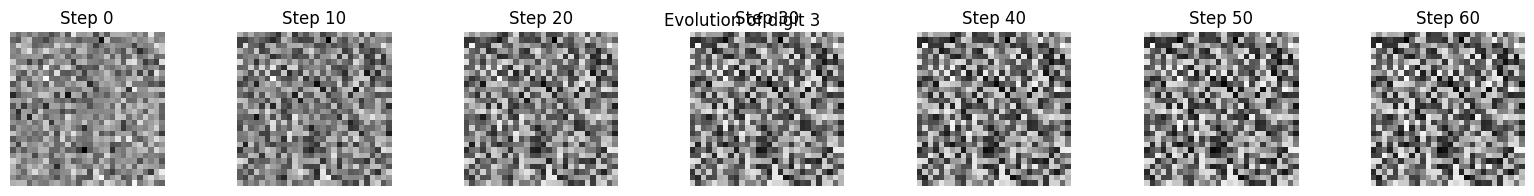

In [25]:
digit_idx = 3  # index from 0 to 9

fig, axes = plt.subplots(1, len(image_snapshots), figsize=(20, 2))
for i, snapshot in enumerate(image_snapshots):
    img = snapshot[digit_idx].squeeze()
    img = (img - img.min()) / (img.max() - img.min())  # normalize
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Step {i*10}")
plt.suptitle(f"Evolution of digit {digit_idx}")
plt.show()

TypeError: Invalid shape (10,) for image data

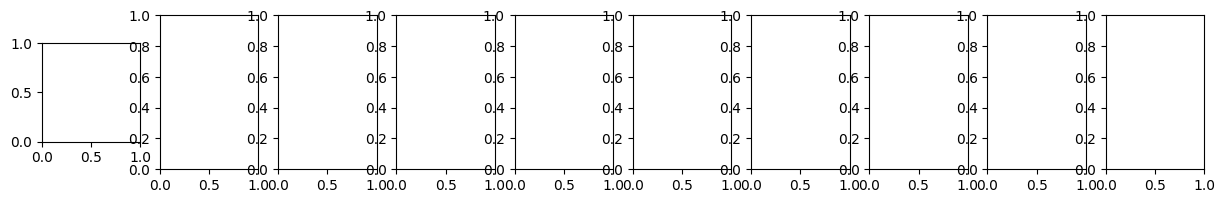

In [22]:
def plot_results(images, confidence_history):
    images = images.cpu().numpy().squeeze()

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(str(i))
    plt.suptitle("Generated Images for Digits 0-9")
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(confidence_history[:, i], label=f"Digit {i}")
    plt.xlabel("Iteration")
    plt.ylabel("Confidence")
    plt.title("Confidence per Digit Over Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
model.to(device)
model.eval()
plot_results(dreamed_images, confidence_history)